# Inferring VC investment trends in 2020 using textual analysis of Twitter data

Venture capitalists (VCs) are known for utilizing a variety of resources, ranging from financial statements and research reports to aggregation platforms such as Crunchbase and Angellist, for uncovering market trends to optimize their investment strategy. An often overlooked resource for performing such market analyses is social media, which can serve as a goldmine of alternate data for providing additional leverage to VCs. One of such social media platforms that is currently popular with entrepreneurs and investors is Twitter, which can serve as an incredibly rich source of textual information indicating market activity that might be relevant for accumulating market intelligence. The goal of this project is to utilize unsupervised learning techniques for performing exploratory analysis on textual data from Twitter to uncover latent market trends, create market maps, and gather market intelligence. 

### Scraping:

Scraping tweets (max 300k) for "vc investment" query during the year 2020 using *snscrape*

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating a list to store the tweet data
tweets_list = []

# Using TwitterSearchScraper to scrape tweets and append to tweets_list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('vc investment since:2020-01-01 until:2020-12-31').get_items()):
    if i>300000: # Only scraping 300000 tweets
        break
    if i%1000 == 0:
        print(i)
    
    # Only appending tweets that are in English and have more than 10 likes
    if tweet.likeCount >= 10 and tweet.lang == "en":
        tweets_list.append(tweet.content)
    
print("Done scraping!")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
Done scraping!


Converting the list of tweets to a Pandas dataframe and saving to file for future analysis.

In [62]:
# Creating a dataframe from tweets_list
tweets_df = pd.DataFrame(tweets_list, columns=["Text"])

# Saving dataframe to file for future analysis
tweets_df.to_pickle("venture_capital_investment.pkl")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Cleaning data:

Step 1: Remove all mentions, links and numbers (words following @, http, and numbers) (Note: not removing hastags as they contain relevant information for topic modeling)

In [64]:
for idx,tweet in enumerate(tweets_df["Text"]):
    tweets_df["Text"][idx] = ' '.join(i for i in tweet.split() if not (i.startswith('@') or i.startswith('http') or i.startswith('$') or i.isdigit()))
    
print(tweets_df["Text"][0])

Also as an aside- I speak about this often- your fave billionaires aren’t even solo, they either came up of a shit ton of angel investment, VC funding or like Bezos had family rich enough to give him circa The romanticisation and promotion of ‘grinding solo’ makes no sense


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 2: Remove all stop words that don't contribute to topic modeling and tokenizing the tweets

In [65]:
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

# Adding punctuations to list of stopwords
stop_words += list(string.punctuation)

# Defining a function for converting to lowercase, tokenizing, and removing stopwords
def tokenize_and_removestopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    return tokens
  
# Applying tokenizing to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
     tweets_df["Text"][idx] = tokenize_and_removestopwords(tweet)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Shobhit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Shobhit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['also', 'aside-', 'speak', 'often-', 'fave', 'billionaires', '’', 'even', 'solo', 'either', 'came', 'shit', 'ton', 'angel', 'investment', 'vc', 'funding', 'like', 'bezos', 'family', 'rich', 'enough', 'give', 'circa', 'romanticisation', 'promotion', '‘', 'grinding', 'solo', '’', 'makes', 'sense']


Step 3: Only select nouns

In [73]:
nltk.download('averaged_perceptron_tagger')

# Selecting only nouns from all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
    updated_tweet = []
    tweet_pos = nltk.pos_tag(tweet)
    [updated_tweet.append(token[0]) for token in tweet_pos if (token[1] == "NN" or token[1] == "NNS")]
    tweets_df["Text"][idx] = updated_tweet

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Shobhit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['billionaire', 'ton', 'family', 'romanticisation', 'promotion', 'sense']


Step 4: Lemmatizing (reducing words to their base meaning)

In [74]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

# Applying lemmatizing to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
     tweets_df["Text"][idx] = lemmatize_text(tweet)

['billionaire', 'ton', 'family', 'romanticisation', 'promotion', 'sense']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /Users/Shobhit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generating a frequency table that will be used to append the list of stopwords in a separate list called *irrelevant_words*

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['investment', 'vc', 'startup', 'fund', 'investor', 'company', 'founder', 'amp', 'firm', 'year', 'venture', 'capital', 'business', 'funding', 'time', 'tech', 'team', 'stage', 'opportunity', 'today', 'market', 'innovation', 'growth', 'deal', '’', 'partner', 'people', 'industry', 'report', 'portfolio', 'world', 'money', 'woman', 'round', 'information', 'vcs', 'seed', 'fintech', 'series', 'search', 'equity', 'traveltech', 'entrepreneur', 'announce', 'impact', 'data', 'return', 'businessangels', 'share', 'strategy']


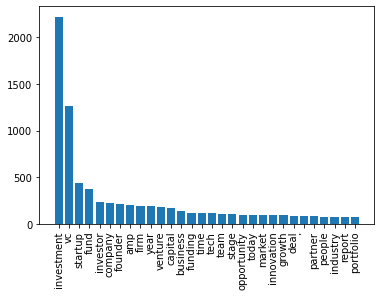

In [68]:
# Iterating through all tweets to construct a frequency table
words_list = [token for tweet in tweets_df["Text"] for token in tweet]

word_freq = nltk.probability.FreqDist(words_list)
most_common = word_freq.most_common(50)
most_common_terms = [term[0] for term in most_common]
most_common_terms_freq = [term[1] for term in most_common]
print(most_common_terms)

# Construct a bar plot to visualize frequencies of top 30 words
import matplotlib.pyplot as plt
plt.bar(x=list(range(1,31)), height=most_common_terms_freq[0:30], tick_label=most_common_terms[0:30])
plt.xticks(rotation = 90)
plt.show()

Removing additional stopwords (stored in *irrelevant words*) based on the top 30 frequent words in the frequency table

In [78]:
# Removing additional words from the tweets database
irrelevant_words = most_common_terms[0:30]
irrelevant_words.extend(["round", "money", "seed", "share", "post", "way", "entrepreneur", "bn", "part", "series", "return", "information", "woman", "impact", "world", "insight", "vcs", "member"])

# Applying filtering to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
    tweets_df["Text"][idx] = [token for token in tweet if token not in irrelevant_words]

['investment', 'vc', 'startup', 'fund', 'investor', 'company', 'founder', 'amp', 'firm', 'year', 'venture', 'capital', 'business', 'funding', 'time', 'tech', 'team', 'stage', 'opportunity', 'today', 'market', 'innovation', 'growth', 'deal', '’', 'partner', 'people', 'industry', 'report', 'portfolio', 'round', 'money', 'seed', 'share', 'post', 'way', 'entrepreneur', 'bn', 'part', 'series', 'return', 'information', 'woman', 'impact', 'world', 'insight', 'vcs', 'member']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating bag of words for LDA topic modeling

In [79]:
from gensim.corpora import Dictionary

# Creating a dictionary from tweets corpus(used to give a unique index to each word in the corpus)
text_dict = Dictionary(tweets_df["Text"])

# Creating bag of words (a frequency table for each tweet using the indices in the dictionary)
tweets_bow = [text_dict.doc2bow(tweet) for tweet in tweets_df["Text"]]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Modeling:

Fitting LDA models to the tweets data with increasing number of topics and computing coherence scores to find the optimum parameters.

In [92]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

coherence = []

for num_topics_ in range(3,12):
    print(num_topics_)
    tweets_lda_ = LdaModel(tweets_bow, num_topics = num_topics_, id2word = text_dict, random_state = 1, passes=50)
    cm = CoherenceModel(model=tweets_lda_, texts=tweets_df["Text"], dictionary=text_dict, coherence='c_v')                           
    coherence.append((num_topics_, cm.get_coherence()))

print("Done finding coherence scores!")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3
4
5
6
7
8
9
10
11
Done finding coherence scores!


Plotting coherence scores against number of topics.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


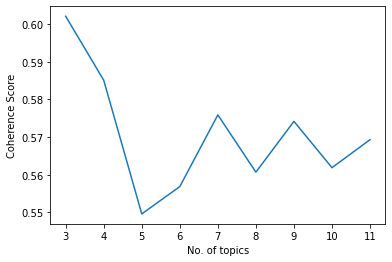

In [94]:
x = [i[0] for i in coherence]
y = [i[1] for i in coherence]
plt.plot(x, y)
plt.ylabel('Coherence Score')
plt.xlabel('No. of topics')
plt.show()

Fitting the model with optimum number of topics (topics leading to maximum coherence score).

In [90]:
tweets_lda = LdaModel(tweets_bow, num_topics = 3, id2word = text_dict, random_state = 1, passes=50)
print("Done fitting!")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Done fitting!


Visualizing the topic modeling output using *pyLDAvis*.

In [91]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.099668  0.095262       1        1  37.194975
0     -0.137915  0.033215       2        1  31.524429
1      0.038246 -0.128477       3        1  31.280597, topic_info=                Term       Freq      Total Category  logprob  loglift
1411          search  44.000000  44.000000  Default  30.0000  30.0000
1994      traveltech  44.000000  44.000000  Default  29.0000  29.0000
1993  businessangels  39.000000  39.000000  Default  28.0000  28.0000
367               pe  26.000000  26.000000  Default  27.0000  27.0000
52         ecosystem  33.000000  33.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
22              work  13.196097  38.057120   Topic3  -5.5552   0.1030
26              week  11.719957  28.079156   Topic3  -5.6738   0.2884
171            group  11.212865  25.011485   Topic3  -5.7180   0.3599
62            record  10.935633  29.781174   Topic3  -5.7431   0.1603
21           support  10.728845  29.514269   Topic3  -5.7621   0.1502

[194 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
126       3  0.832391   ability
358       1  0.987474    access
1045      2  0.923014   account
184       1  0.330293  activity
184       3  0.660586  activity
...     ...       ...       ...
26        3  0.427363      week
22        1  0.420421      work
22        2  0.210210      work
22        3  0.341592      work
996       3  0.932602         👉

[251 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Initial impressions:
- 